In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import japanize_matplotlib
import scipy as sp
from sklearn.covariance import GraphLasso
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.preprocessing import PowerTransformer
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
df=pd.read_csv("baseball_stats.csv")

In [3]:
df.columns

Index(['順　位', '選　手', '選　手.1', '打　率', '試　合', '打　席', '打　数', '得　点', '安　打', '二塁打',
       '三塁打', '本塁打', '塁　打', '打　点', '盗　塁', '盗塁刺', '犠　打', '犠　飛', '四　球', '故意四',
       '死　球', '三　振', '併殺打', '長打率', '出塁率', 'year', 'league'],
      dtype='object')

In [4]:
df.head()

,順 位,選 手,選 手.1,打 率,試 合,打 席,打 数,得 点,安 打,二塁打,三塁打,本塁打,塁 打,打 点,盗 塁,盗塁刺,犠 打,犠 飛,四 球,故意四,死 球,三 振,併殺打,長打率,出塁率,year,league
0,1,糸井 嘉男,(オ),0.331,140,590,502,73,166,36,2,19,263,81,31,9,0,4,70,7,14,73,7,0.524,0.424,2014,p
1,2,銀次,(楽),0.327,117,509,459,59,150,26,0,4,188,70,1,4,1,4,43,0,2,45,10,0.410,0.384,2014,p
2,3,柳田 悠岐,(ソ),0.317,144,615,524,91,166,18,4,15,237,70,33,6,0,3,72,5,16,131,8,0.452,0.413,2014,p
3,4,中村 晃,(ソ),0.308,143,638,571,75,176,22,4,4,218,61,10,2,3,2,59,2,3,61,4,0.382,0.375,2014,p
4,5,内川 聖一,(ソ),0.307,122,534,488,50,150,26,1,18,232,74,0,0,0,7,34,6,5,48,5,0.475,0.354,2014,p


# 偏相関

In [5]:
#他の数値から計算可能なものを削除
X=df.iloc[:,3:-2].drop(["塁　打","打　数","長打率","出塁率","試　合"],axis=1)
#多重共線性があるものは事前に削除
label=list(df.iloc[:,3:-2].columns)
dellist=["塁　打","打　数","長打率","出塁率","試　合"]
for i in dellist:
    label.remove(i)

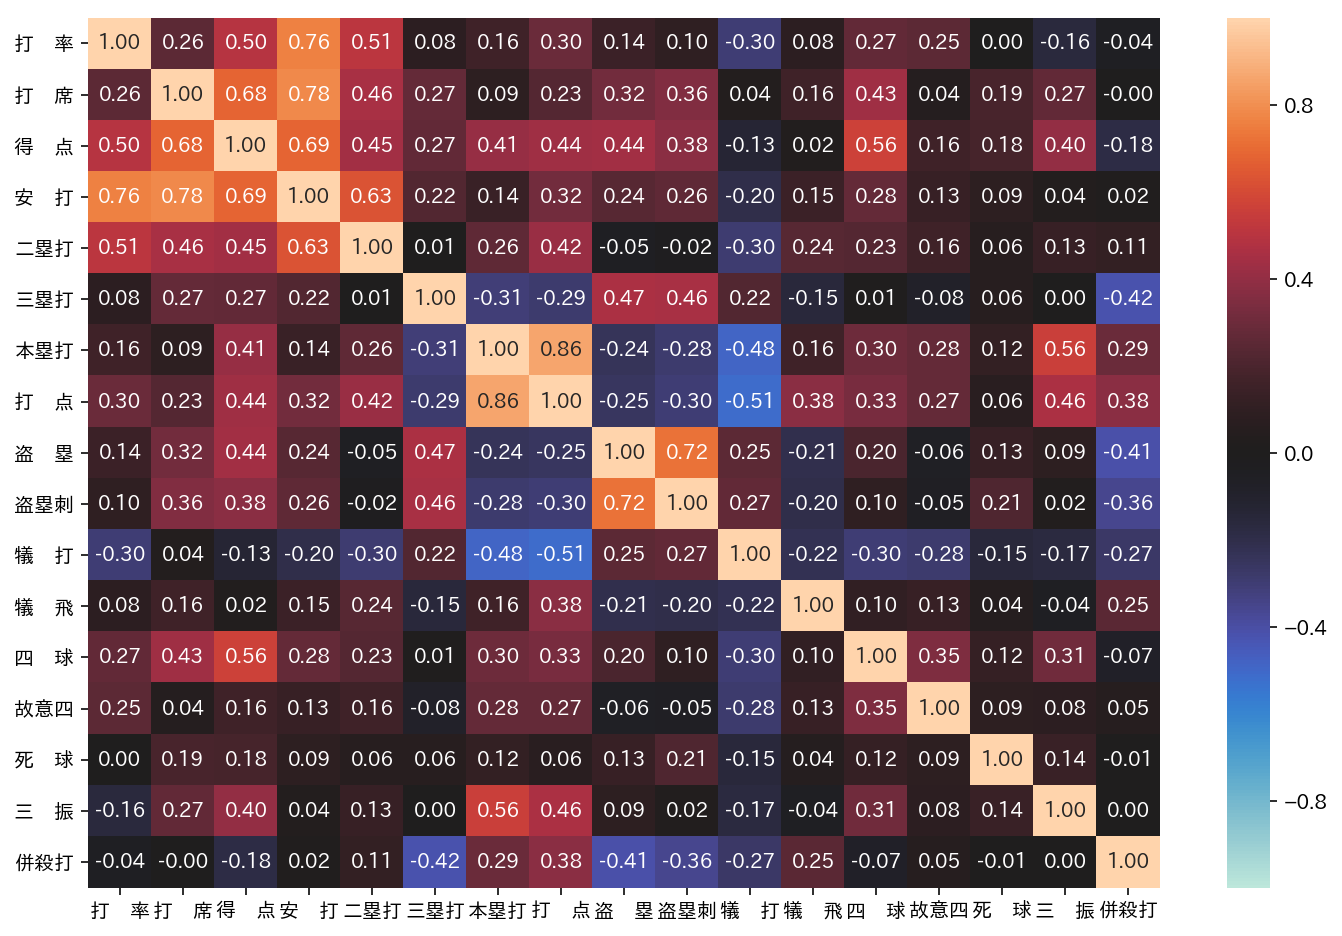

In [6]:
#相関
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(),annot=True,fmt='0.2f',xticklabels=label, yticklabels=label,vmin=-1,vmax=1,center=0)

In [7]:
#精度行列の作成
X_cov_inv = sp.linalg.inv(X.cov()) #共分散の逆行列
pcm = np.empty_like(X_cov_inv)
for i in range(X_cov_inv.shape[0]):
    for j in range(X_cov_inv.shape[0]):
        pcm[i, j] = X_cov_inv[i, j]/np.sqrt(X_cov_inv[i, i]*X_cov_inv[j, j])

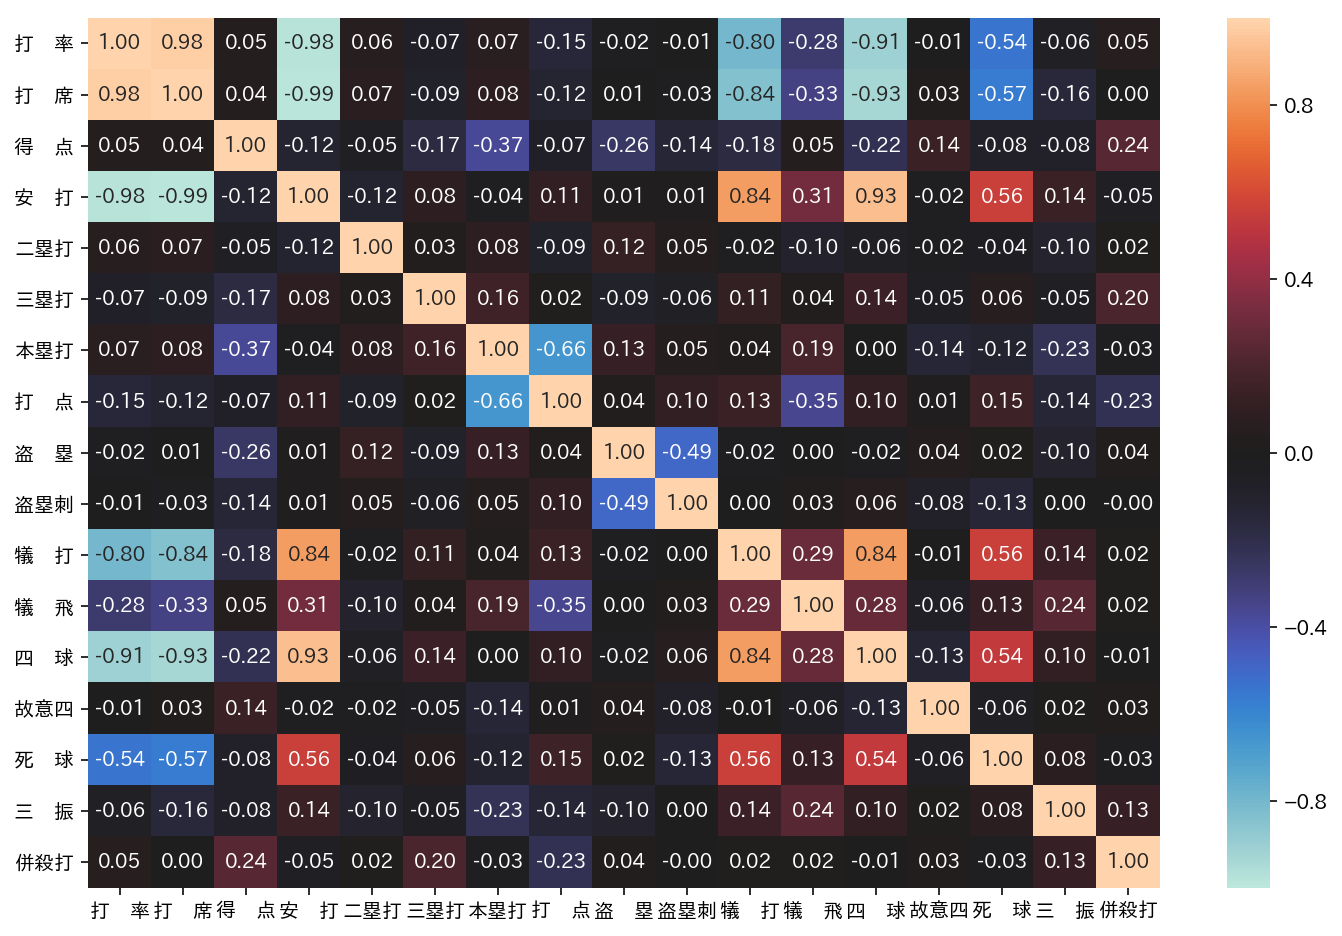

In [8]:
#精度行列
plt.figure(figsize=(12,8))
sns.heatmap(pcm,annot=True,fmt='0.2f',xticklabels=label, yticklabels=label,vmin=-1,vmax=1,center=0)

# Graphical Lasso

In [9]:
#標準化、boxcox変換
X_gl = pd.DataFrame(StandardScaler().fit_transform(df.iloc[:,3:-2].drop(["塁　打","打　数","長打率","出塁率","試　合"],axis=1)))
pt = PowerTransformer()
df_gl = pd.DataFrame(pt.fit_transform(X_gl))

In [10]:
#Graphical Lasso
alpha = 0.2 # L１正則化パラメーター
model = GraphLasso(alpha=alpha,
                     max_iter=100,                     
                     verbose=True,
                     assume_centered = True)

model.fit(X_gl)
cov_ = model.covariance_ # 分散共分散行列
prec_ = model.precision_ # 精度行列

[graphical_lasso] Iteration   0, cost  7.64e+01, dual gap 9.929e-01
[graphical_lasso] Iteration   1, cost  7.63e+01, dual gap -1.316e-02
[graphical_lasso] Iteration   2, cost  7.63e+01, dual gap -1.249e-03
[graphical_lasso] Iteration   3, cost  7.63e+01, dual gap -1.545e-04
[graphical_lasso] Iteration   4, cost  7.63e+01, dual gap -1.233e-05


/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class GraphLasso is deprecated; The 'GraphLasso' was renamed to 'GraphicalLasso' in version 0.20 and will be removed in 0.22.
  warnings.warn(msg, category=DeprecationWarning)


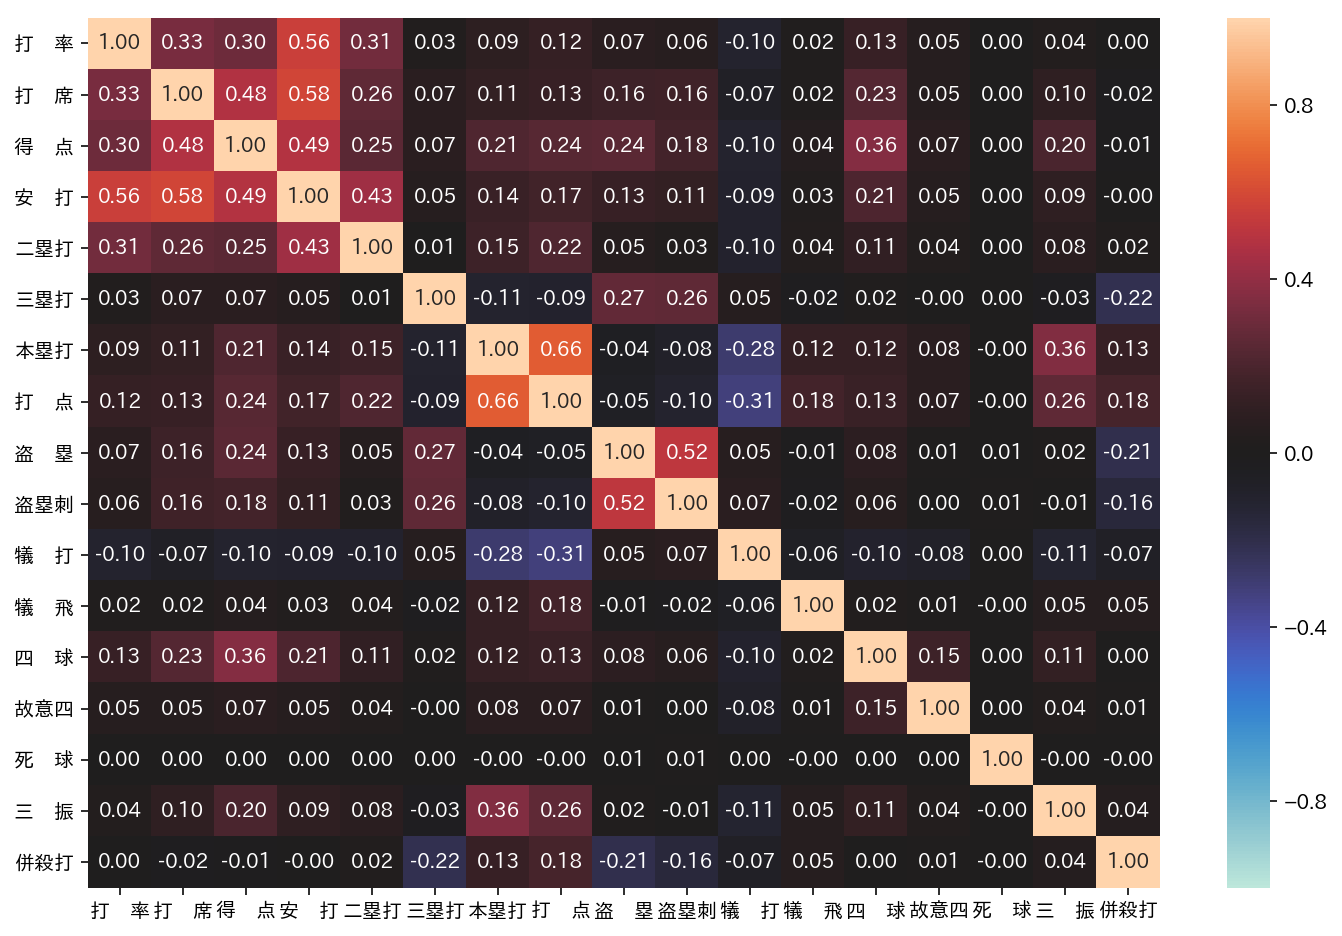

In [11]:
#相関
plt.figure(figsize=(12,8))
sns.heatmap(cov_,annot=True,fmt='0.2f',xticklabels=label, yticklabels=label,vmin=-1,vmax=1,center=0)

In [12]:
X_cov_inv = sp.linalg.inv(cov_) #共分散の逆行列
pcm = np.empty_like(X_cov_inv)
for i in range(X_cov_inv.shape[0]):
    for j in range(X_cov_inv.shape[0]):
        pcm[i, j] = X_cov_inv[i, j]/np.sqrt(X_cov_inv[i, i]*X_cov_inv[j, j])

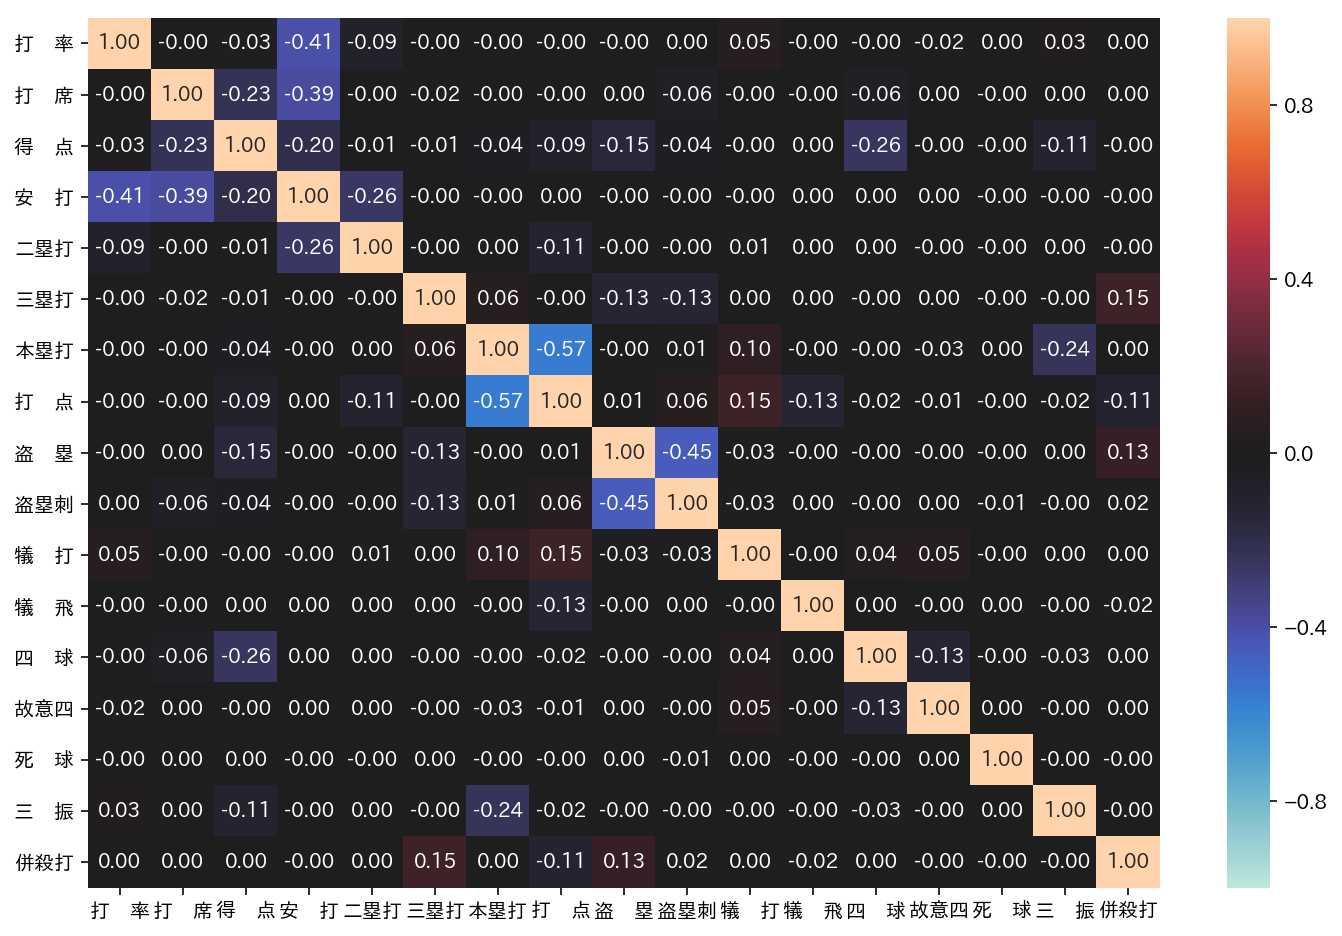

In [13]:
#精度行列
plt.figure(figsize=(12,8))
sns.heatmap(pcm,annot=True,fmt='0.2f',xticklabels=label, yticklabels=label,vmin=-1,vmax=1,center=0)